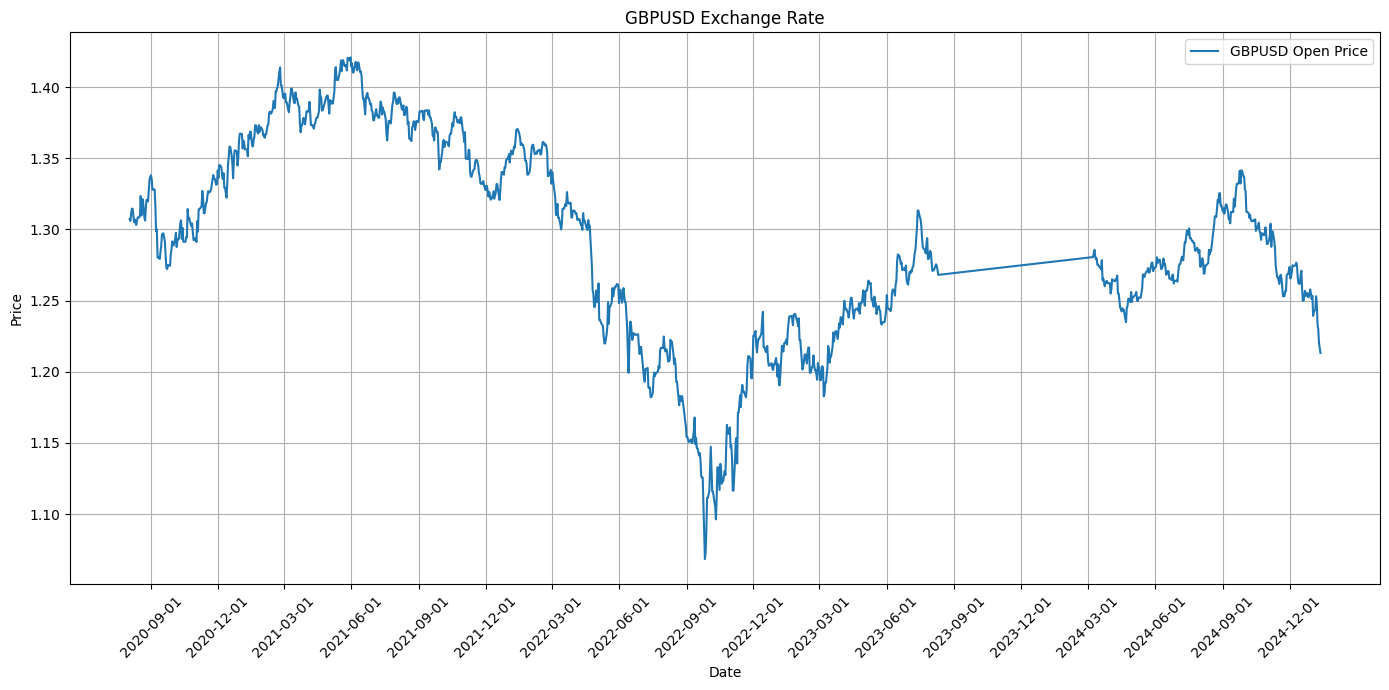

Training Data: (840, 3)
Validation Data: (180, 3)
Test Data: (180, 3)


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "gru_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Load and preprocess the data
df = pd.read_csv('GBPUSD_open_5year.csv')

df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.sort_values(by="Date", inplace=True)

# Plot the GBPUSD exchange rate
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Open'], label='GBPUSD Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GBPUSD Exchange Rate')
plt.xticks(pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='3MS'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Set the 'Date' column as index
df.set_index('Date', inplace=True)

# Split the data into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

print(f"Training Data: {train_data.shape}")
print(f"Validation Data: {val_data.shape}")
print(f"Test Data: {test_data.shape}")

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data[['Open', 'Time']])

target = 'Open'
y_val = val_data[target].values
y_test = test_data[target].values
y_train = train_data[target].values

X_train = scaler.transform(train_data[['Open', 'Time']])
X_val = scaler.transform(val_data[['Open', 'Time']])
X_test = scaler.transform(test_data[['Open', 'Time']])

# Reshaping the data for GRU (3D: samples, time_steps, features)
time_steps = 60
X_train_gru = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_val_gru = X_val.reshape(X_val.shape[0], time_steps, X_val.shape[1])
X_test_gru = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# Build the GRU model
gru_model = Sequential()

# GRU layer with 64 units and ReLU activation
gru_model.add(GRU(units=64, activation='relu', input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=32, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=16, activation='relu'))

# Add Dense layers
gru_model.add(Dense(units=8, activation='relu'))
gru_model.add(Dense(units=1))  # Output layer

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
history_gru = gru_model.fit(X_train_gru, y_train, epochs=100, batch_size=32, validation_data=(X_val_gru, y_val))

# Evaluate the model on test data
test_loss_gru = gru_model.evaluate(X_test_gru, y_test)
print(f"Test Loss (GRU): {test_loss_gru}")

# Predict using the model
y_pred_gru = gru_model.predict(X_test_gru)

# Inverse transform predictions to get the actual values
y_pred_gru_actual = scaler.inverse_transform(np.column_stack((y_pred_gru, np.zeros(y_pred_gru.shape))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros(y_test.shape))))[:, 0]

# Calculate performance metrics
mae_gru = mean_absolute_error(y_test_actual, y_pred_gru_actual)
mse_gru = mean_squared_error(y_test_actual, y_pred_gru_actual)
r2_gru = r2_score(y_test_actual, y_pred_gru_actual)
mape_gru = np.mean(np.abs((y_test_actual - y_pred_gru_actual) / y_test_actual)) * 100

print(f"GRU Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_gru:.4f}")
print(f"Mean Squared Error (MSE): {mse_gru:.4f}")
print(f"R² Score: {r2_gru:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gru:.2f}%")

# Plotting the loss, MAE, and MSE for training and validation
history_dict = history_gru.history

# Loss plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 3, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

# MSE plot
plt.subplot(1, 3, 3)
plt.plot(history_dict['mse'], label='Training MSE')
plt.plot(history_dict['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


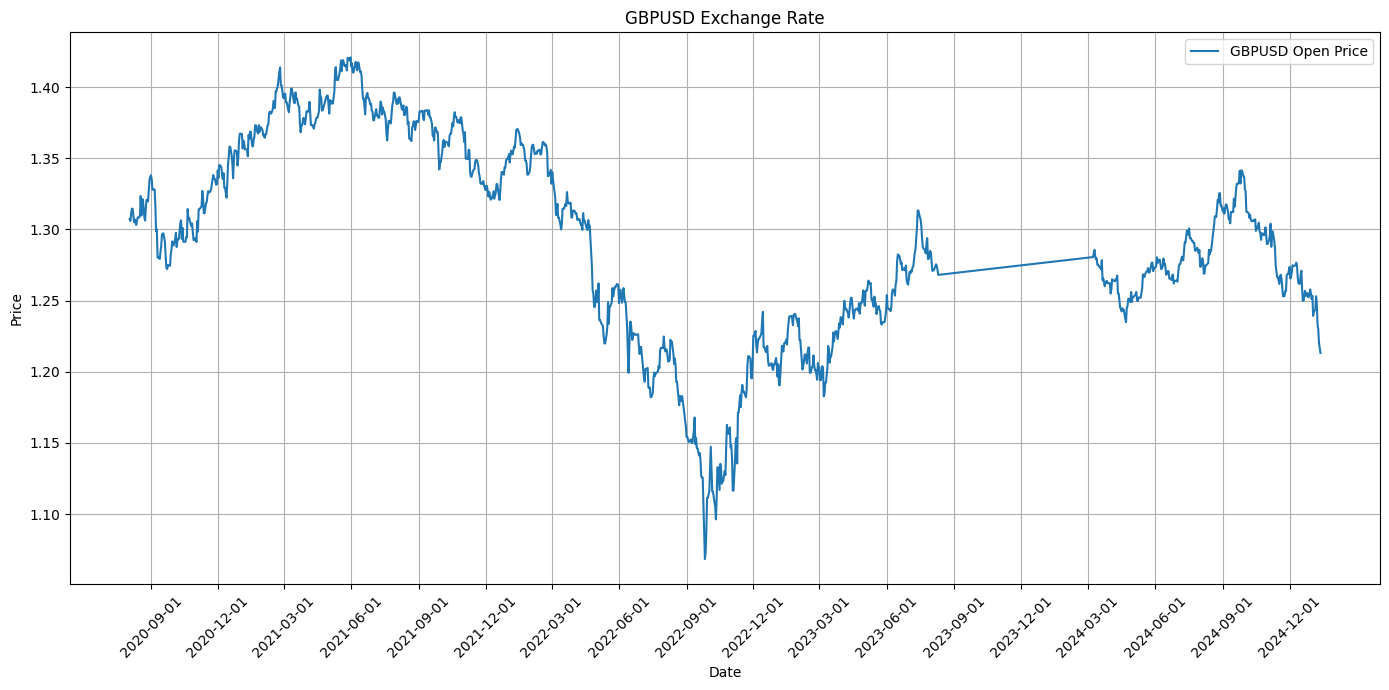

Training Data: (840, 3)
Validation Data: (180, 3)
Test Data: (180, 3)
Epoch 1/100


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 1.6424 - mae: 1.2789 - mse: 1.6424 - val_loss: 1.3803 - val_mae: 1.1747 - val_mse: 1.3803
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3734 - mae: 1.1675 - mse: 1.3734 - val_loss: 0.6197 - val_mae: 0.7868 - val_mse: 0.6197
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5428 - mae: 0.6842 - mse: 0.5428 - val_loss: 0.3052 - val_mae: 0.5377 - val_mse: 0.3052
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1214 - mae: 0.2771 - mse: 0.1214 - val_loss: 0.0530 - val_mae: 0.2131 - val_mse: 0.0530
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1139 - mae: 0.2730 - mse: 0.1139 - val_loss: 0.0423 - val_mae: 0.1913 - val_mse: 0.0423
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0996 - mae: 0.2500 - mse: 0.0996 - val_loss: 0.0244 - val_mae: 0.1422 - val_mse: 0.0244
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0987 - mae: 0.2507 - mse: 0.0987 - val_loss: 0.0201 - va

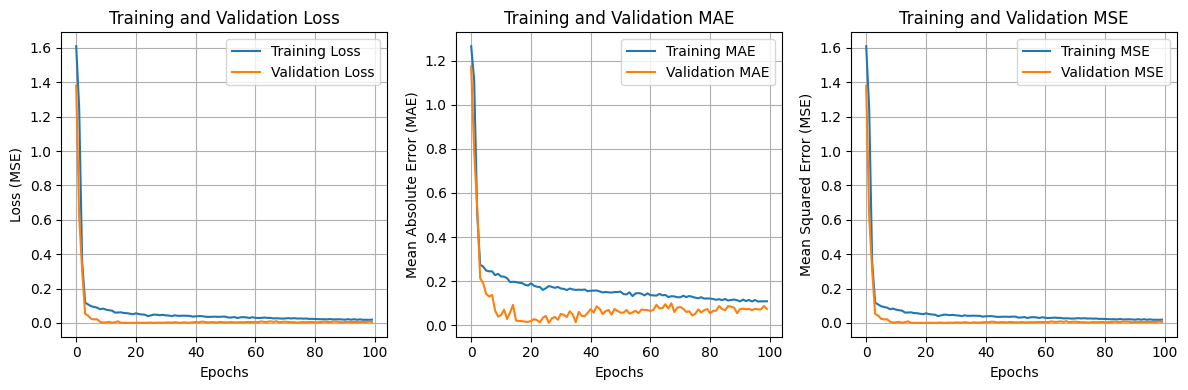

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Load and preprocess the data
df = pd.read_csv('GBPUSD_open_5year.csv')

df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.sort_values(by="Date", inplace=True)

# Plot the GBPUSD exchange rate
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Open'], label='GBPUSD Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GBPUSD Exchange Rate')
plt.xticks(pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='3MS'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Set the 'Date' column as index
df.set_index('Date', inplace=True)

# Split the data into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

print(f"Training Data: {train_data.shape}")
print(f"Validation Data: {val_data.shape}")
print(f"Test Data: {test_data.shape}")

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data[['Open', 'Time']])

target = 'Open'
y_val = val_data[target].values
y_test = test_data[target].values
y_train = train_data[target].values

X_train = scaler.transform(train_data[['Open', 'Time']])
X_val = scaler.transform(val_data[['Open', 'Time']])
X_test = scaler.transform(test_data[['Open', 'Time']])

# Reshaping the data for GRU (3D: samples, time_steps, features)
time_steps = 1  # Time steps can be adjusted depending on your requirements
X_train_gru = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_val_gru = X_val.reshape(X_val.shape[0], time_steps, X_val.shape[1])
X_test_gru = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# Build the GRU model
gru_model = Sequential()

# GRU layer with 64 units and ReLU activation
gru_model.add(GRU(units=64, activation='relu', input_shape=(X_train_gru.shape[1], X_train_gru.shape[2]), return_sequences=True))
gru_model.add(Dropout(0.2))

# Add more GRU layers with return_sequences=True for the layers except the last one
gru_model.add(GRU(units=32, activation='relu', return_sequences=True))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=16, activation='relu', return_sequences=False))  # No need for return_sequences=True here
gru_model.add(Dropout(0.2))

# Add Dense layers
#gru_model.add(Dense(units=8, activation='relu'))
gru_model.add(Dense(units=1))  # Output layer

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
history_gru = gru_model.fit(X_train_gru, y_train, epochs=100, batch_size=32, validation_data=(X_val_gru, y_val))

# Evaluate the model on test data
test_loss_gru = gru_model.evaluate(X_test_gru, y_test)
print(f"Test Loss (GRU): {test_loss_gru}")

# Predict using the model
y_pred_gru = gru_model.predict(X_test_gru)

# Inverse transform predictions to get the actual values
y_pred_gru_actual = scaler.inverse_transform(np.column_stack((y_pred_gru, np.zeros(y_pred_gru.shape))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros(y_test.shape))))[:, 0]

# Calculate performance metrics
mae_gru = mean_absolute_error(y_test_actual, y_pred_gru_actual)
mse_gru = mean_squared_error(y_test_actual, y_pred_gru_actual)
r2_gru = r2_score(y_test_actual, y_pred_gru_actual)
mape_gru = np.mean(np.abs((y_test_actual - y_pred_gru_actual) / y_test_actual)) * 100

print(f"GRU Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_gru:.4f}")
print(f"Mean Squared Error (MSE): {mse_gru:.4f}")
print(f"R² Score: {r2_gru:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gru:.2f}%")

# Plotting the loss, MAE, and MSE for training and validation
history_dict = history_gru.history

# Loss plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 3, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

# MSE plot
plt.subplot(1, 3, 3)
plt.plot(history_dict['mse'], label='Training MSE')
plt.plot(history_dict['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

